In [0]:
#!unzip "drive/My Drive/Dog Vision/sample_submission.csv.zip" -d "drive/My Drive/Dog Vision/Data"

In [0]:
#!unzip "drive/My Drive/Dog Vision/train.zip" -d "drive/My Drive/Dog Vision/Data/train"

In [0]:
#!unzip "drive/My Drive/Dog Vision/test.zip" -d "drive/My Drive/Dog Vision/Data/test"

# 🐶 Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds
Who's that doggy in the window?

Dogs are incredible. But have you ever been sitting at a cafe, seen a dog and not known what breed it is? I have. And then someone says, "it's an English Terrier" and you think, how did they know that?

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the Kaggle dog breed identification competition. It consists of a collection of 10,000+ labelled images of 120 different dog breeds. - https://www.kaggle.com/c/dog-breed-identification/data

### This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

## We're going to go through the following TensorFlow/Deep Learning workflow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels) - Evaluation is a file with prediction probabilties for each dog breed of each test image.
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

# Getting our workspace ready
Before we get started, since we'll be using TensorFlow 2.x and TensorFlow Hub (TensorFlow Hub), let's import them.

NOTE: Don't run the cell below if you're already using TF 2.x.

* Import Tensorflow 2.X
* Import Tensorflow Hub
* Make sure we're using a GPU

In [1]:
# Import necessary tools into Colab
import tensorflow as tf
import tensorflow_hub as hub
print('TF version: ', tf.__version__)
print('TF Hub Version: ', hub.__version__)

# Check out GPU availability 
print("GPU", ' is avaialble (YES!!)' if tf.config.list_physical_devices("GPU") else " not available :(")

TF version:  2.2.0
TF Hub Version:  0.8.0
GPU  is avaialble (YES!!)


#### Tensorflor Hub 
TensorFlow Hub is a library for reusable machine learning modules. ... A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning.

#### How to select the GPU?
Runtime --> Change Rntime --> select GPU and save

## Getting our data ready (turning into Tensors)
With all machine learning models, data has to be in numerical format.
So, we'll turn images into tensors (numerical representations).

In [2]:
# Checkout labels.csv

import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/Data/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     7b0ca504f40cfdb1480fa6b5cd8f84bd  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64


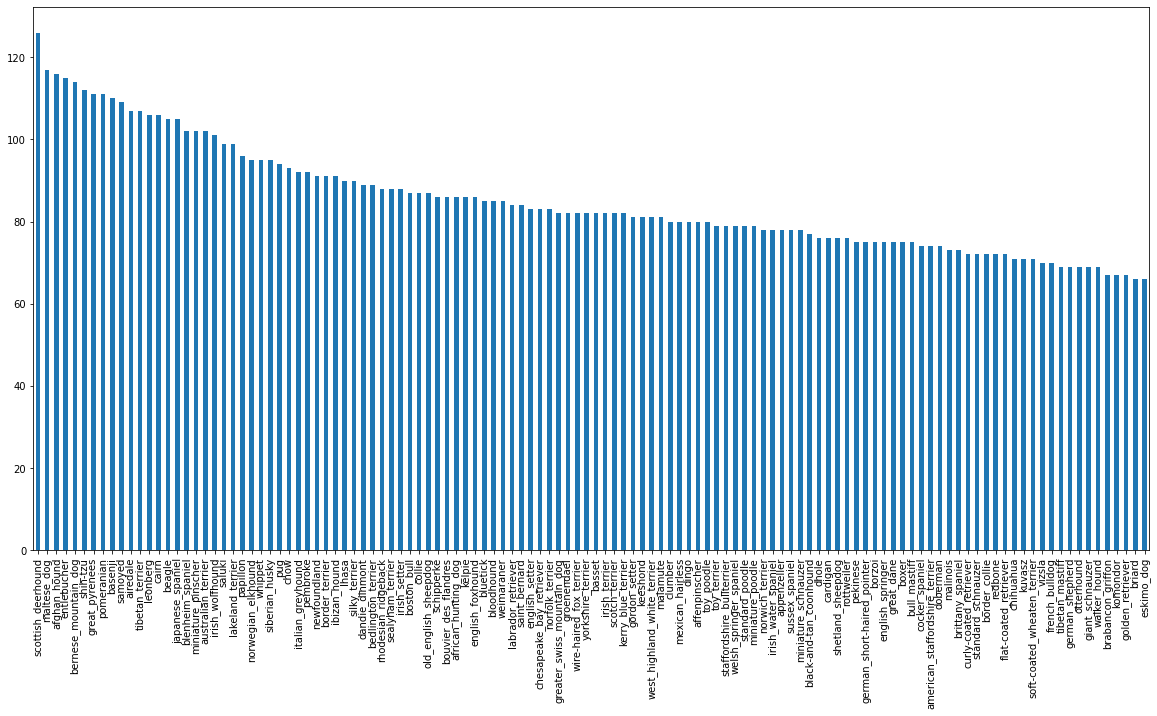

In [0]:
# How many images are there per each breed
print(labels_csv['breed'].value_counts())
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [0]:
labels_csv['breed'].value_counts().median()

82.0

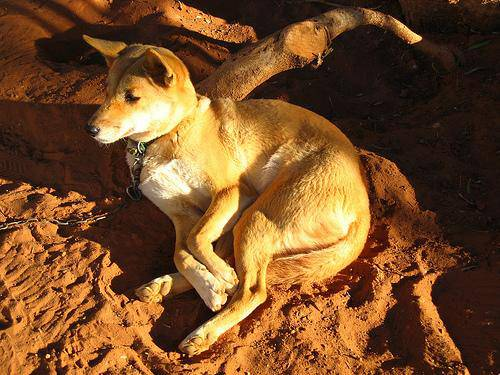

In [0]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels
Let's get a list of all of our images file pathnames

In [3]:
# Create pathname from image id
filenames = ["drive/My Drive/Dog Vision/Data/train/" +fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog Vision/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/Data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/Data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/Data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/Data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/Data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/Data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/Data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
# Check whether number of filenames is equal to actual image files
import os
if (len(os.listdir('drive/My Drive/Dog Vision/Data/train')) == len(filenames)):
  print("Filenames match the actual amount")
else:
  print('filenames do not match the actual amount')

Filenames match the actual amount


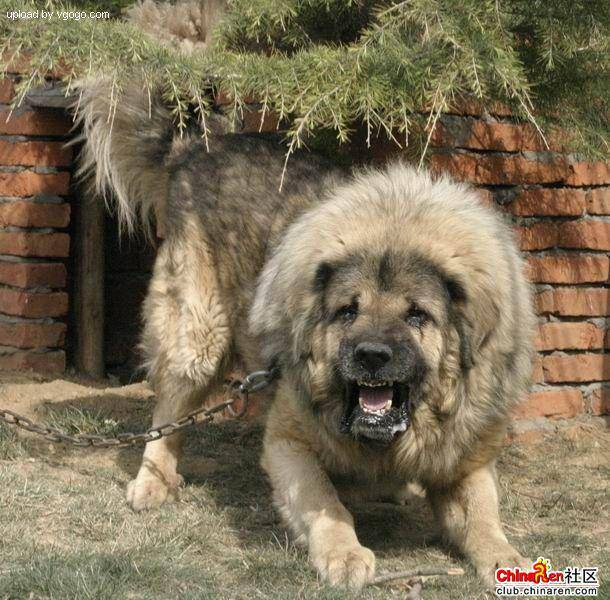

In [0]:
Image(filenames[9000])

In [0]:
labels_csv['breed'][9000]

'tibetan_mastiff'

In [0]:
len(os.listdir('drive/My Drive/Dog Vision/Data/train')), len(os.listdir('drive/My Drive/Dog Vision/Data/test')), labels_csv.count()

(10222, 10357, id       10222
 breed    10222
 dtype: int64)

#### Since we've now got training image filepaths in a list, let's prepare our labels

In [4]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
#labels = np.array(labels)  # does same thing as .to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
len(labels)

10222

In [0]:
# Check if number of labels matches number of filenames
if len(labels) == len(filenames):
  print('No of data MATCHES no of filenames')
else:
  print('No of data does NOT matches no of filenames')

No of data MATCHES no of filenames


In [5]:
# Find unique label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [0]:
# Turn a single label into array of boolean
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [6]:
# Tuen every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
len(boolean_labels)

10222

In [0]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))  #index where label occurs
print(boolean_labels[0].argmax())  # index where label apppears in boolean array
print(boolean_labels[0].astype(int))   #there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [0]:
print(labels[2])
print(boolean_labels[2].astype(int)) 

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
since kaggle doesn't give us validation set, we'll create our own

In [0]:
# Create X and y
X = filenames
y= boolean_labels

We're going to start off experimenting with ~1000 and increase as needed

In [0]:
# Set no of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [9]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split

# splitting into training and validation sets of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [0]:
# Let's have a look at training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/Data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/Data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/Data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/Data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/Data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False

## Pre-processing Images - Turning images into Tensors


Before we do, lets see what importing an image looks like.



In [10]:
# Convert image into numpy array
# imread = image read
from matplotlib.pyplot import imread 
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
image.max(), image.min()

(255, 0)

In [0]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [0]:
# tf.constant() = Creates a constant tensor from a tensor-like object.
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

####We'll write a function here:
1. Take image filepath as input
2. Use Tensorfow to read the file and save it as a variable 'image'
3. Turn 'image' (a jpg) into tensors
4. Normalize our image (convert color channels from 0-255 to 0-1)
5. Resize image to be in shape of (224,224)
6. Return the modeified image


In [0]:
# Lets write our function
# Define image size
IMG_SIZE = 224

# Create the function for pre processing image
def process_image(img_path, img_size=IMG_SIZE):
  '''
  Takes an image filepath and convert the image into tensor
  '''
  # Read in an image file
  image = tf.io.read_file(img_path)
  # Turn jpeg image into numerical tensor with 3 color channels (Red, Green and Blue)
  image = tf.image.decode_jpeg(image, channels =3)
  # Convert color channel values from range of 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])
  
  return image

### Turning our data into batches

* Why turn our data into batches?

Ans. Let's say you're trying to process 10000+ images in one go, it might not fit into memory. Thats why we do about 32 (batch size) images at a time. You can manually adjust batch size if needed.

In order to use tensorflow, we need our data in form of tensor tuples which look like this : (image, label)

In [0]:
# Create a simple function that returns a tuple of tensors (image, label)

def get_image_label(image_path, label):
  '''
  Takes an image file path name and its associated label and returns in the form of (image, label)
  '''
  image = process_image(image_path)
  return image, label

#### Let's make all our data X and y into 'batches'

In [0]:
# Define batch size, 32 is a good start
BATCH_SIZE = 32

# Create function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False,test_data= False):
  '''
   Creates batches of data out of image (X) and label (y) pairs.
   Shuffles the data if its training data but doesn't shuffle in case of validation data.
   Also accepts test data as input (no labels)
  '''
  # If data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches ...")
    data= tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If data is validation data set, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepath
                                              tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If data is training set, create data batches (we need to shuffle)
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                           tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images 
    data= data.shuffle(buffer_size= len(X))
    
    # Create (image, label) tuples (this also turns image path into preprocessed image)
    data = data.map(get_image_label)
    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch    


In [14]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [0]:
# Check out different attributes of our data batches
train_data.element_spec, val_data.element_spec

# in X, shape = None (its the batch size, here its None even though we assigned batch size as 32 as its flexible)
# in y, 120 is the size because we have total dog breeds equal to 120, so its size becomes 120 

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visaulizing data batches

Our data is now in batches, let's visualize them.

In [0]:
import matplotlib.pyplot as plt
# Create a function for viewing images in data batch

def show_25_images(images, labels):
  '''
  Displays a plot of 25 images and their labels from a data batch
  '''
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop throigh 25 images
  for i in range(25):
    # create subplots 5 rows and 5 cols
    ax = plt.subplot(5,5, i+1)   # row, col, index
    # Dsiplay an image
    plt.imshow(image[i])
    # Add image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off
    plt.axis('off')

In [0]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [16]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

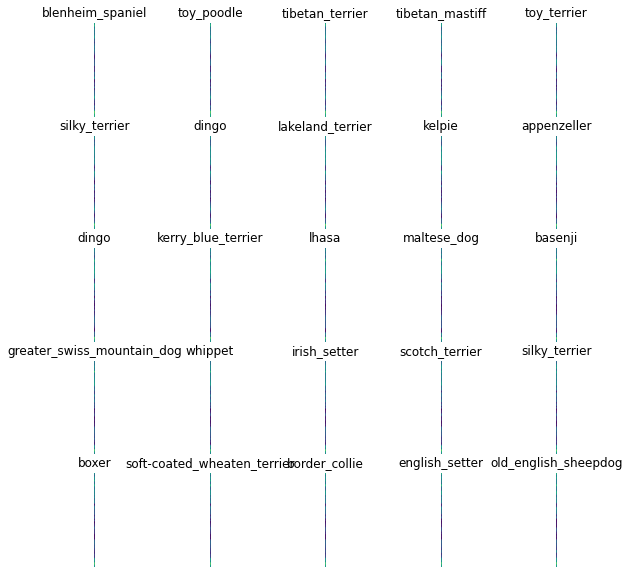

In [0]:
show_25_images(train_images, train_labels) # these 25 images will be diff everytime, bcz each time we call train_batch, train data is shuffled

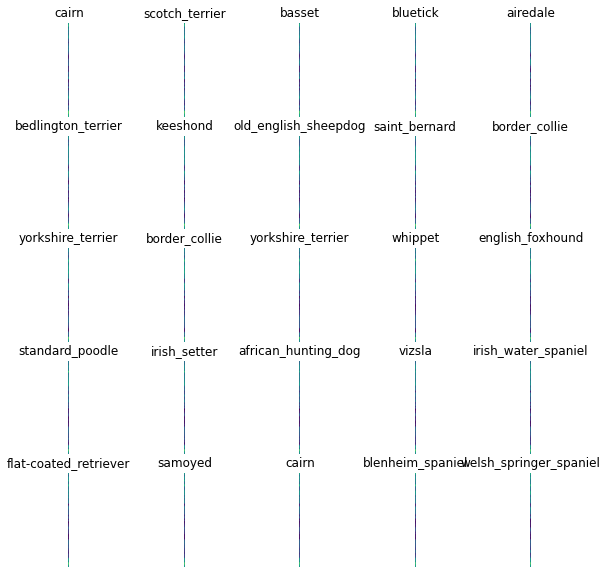

In [17]:
# lets do the same for validation batch

val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels) # images don't change bcz we don't shuffle validation set

## Building a model

Before we build a model, there a few things we need to define.
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Tensorflow hub -https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, widht, color channels

# Setup output shapeof our model
OUTPUT_SHAPE = len(unique_breeds)
            
# Setup model url from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Since we got our input, output and model ready. 
Let's put them together into Kera deep learning model.

Create function:
* Takes input shape, output shape and model we've chosen as parameters
* Defines the layers in Kera model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

All steps can be found here : https://www.tensorflow.org/guide/keras/overview

In [0]:
# create a function which build a Keras model
def create_model(input_shape= INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with: " , MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL),  # Layer 1 (input layer)
                               tf.keras.layers.Dense(units= OUTPUT_SHAPE,
                                                     activation = "softmax")  # Layer 2 (output Layer)
   ])   
  
  # Compile the model 
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics= ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [20]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper function that a model caan use while its training to do such things as save its progress, check its progress ot stop training early if the model stops making progress.

We'll  create 2 callbacks - One for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

### TensorBoard Callback

To setup TensorBoard callback, we need to do 3 things:

1. Load the tensorboard notebook extension
2. Create a TensorBoard Callback which is able to save logs to directory and pass it to our model's 'fit' function
3. Visualize our model's training logs with "%tensorboard" magic function (we'll do this after model training)

In [0]:
# Load tensorboard notebook extension 
%load_ext tensorboard

In [0]:
import datetime
import os

# Create a function to build TensorBoard Callback
def create_tensorboard_callback():
  # create a log directory for storing tensorboard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/Logs",
                        # MAke it so that logs gets tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%M%d-%H%M%S")
                        )
  return tf.keras.callbacks.TensorBoard(logdir)

### EArly stopping callback

Early stopping stops our model by overfitting by stopping training is a certail evaluation metric stops improving : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Training a model (on subset of data)
 Our first model is going to train on 1000 images, to make sure everything is working

In [0]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100, step:10 }

In [25]:
# Check to make sure we're still running on gpu
print("GPU availabale" if tf.config.list_physical_devices('GPU') else "GPU not available")

GPU availabale


Let's create a function to train a model:

* create a model using 'create_model()'
* Setup a tendorboard callback using 'create_tensorboard_callback()'
* Call 'fit()' function on the model passing training data, validation data, no of epochs to trainfor (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model


In [0]:
# build a function to train a model and return trained model
def train_model():

  #Create a model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq=1,
            callbacks = [tensorboard, early_stopping])
  
  # return the fitted model
  return model

In [27]:
# Fit the model to the data
model = train_model() 
# Trains for 25 steps ( train data =800; 800/32 = 25) and validates fot 7 steps (200/32 = 6.25)
# ETA = Estimated time of arrival
# First epoch will take a lot of time, but subsequent epochs will tun very fast on training and validation data
# Since our model is performing way better on training data than on validation data, our model is overfitting

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 662s 26s/step - loss: 4.6280 - accuracy: 0.0887 - val_loss: 3.4913 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 6s 259ms/step - loss: 1.6215 - accuracy: 0.6850 - val_loss: 2.2142 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 6s 258ms/step - loss: 0.5546 - accuracy: 0.9450 - val_loss: 1.7461 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 7s 262ms/step - loss: 0.2416 - accuracy: 0.9912 - val_loss: 1.5368 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 6s 256ms/step - loss: 0.1443 - accuracy: 0.9975 - val_loss: 1.4754 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 6s 257ms/step - loss: 0.0991 - accuracy: 1.0000 - val_loss: 1.4207 - val_accuracy: 0.6350
Epoch 7/100
25/25 [=============================

**Question:** What are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing. It means our model is learning!

### Checking the TensorBoard logs

Tensorboard magic function (%tensorboard) will access the logs directly and visaulize its contents

In [28]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/Logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using trained model

In [29]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [30]:
# Make prediction on validation data ( not used to train on)
predictions = model.predict(val_data, verbose=1)   # verbose=1 (for progress bar)
predictions

7/7 [==============================] - 1s 164ms/step


array([[3.5573319e-03, 4.7520782e-05, 9.7854016e-03, ..., 4.6336898e-04,
        4.3476921e-05, 9.3437271e-04],
       [2.4518473e-03, 2.9232531e-04, 1.5340149e-02, ..., 4.9361895e-04,
        2.9044801e-03, 6.5345746e-05],
       [1.9839816e-05, 1.1327172e-04, 7.2535249e-07, ..., 9.9299883e-05,
        5.9406539e-06, 1.2614028e-04],
       ...,
       [9.8005103e-07, 2.0120247e-05, 4.9214805e-06, ..., 8.8559691e-06,
        1.6162017e-05, 2.9985085e-05],
       [1.6467476e-02, 3.7860594e-04, 1.6249741e-04, ..., 1.6222551e-04,
        2.3915592e-04, 5.8181744e-02],
       [3.6141000e-04, 1.1423417e-05, 5.9694733e-04, ..., 2.7079009e-03,
        1.0531010e-04, 1.8983830e-05]], dtype=float32)

In [31]:
predictions.shape, len(y_val), len(predictions[0])

((200, 120), 200, 120)

In [32]:
predictions[0]  #each value is the probability of being that breed. The position at which the probability is highest, dog is of that breed
# these probabilities are coming in range of 0-1 and sum upto be 1 because we have softmax. (Read SOFTMAX)

array([3.55733186e-03, 4.75207817e-05, 9.78540163e-03, 6.57246783e-05,
       1.79187089e-04, 6.39272093e-06, 1.17166946e-02, 5.60679997e-04,
       2.27018463e-04, 1.74699619e-03, 2.48074881e-04, 1.03253806e-04,
       1.06769941e-04, 1.83727287e-04, 4.63056902e-04, 3.70022171e-04,
       1.03553284e-04, 1.15886010e-01, 1.19113256e-05, 6.09554581e-06,
       4.51299129e-04, 3.43891406e-05, 1.05075987e-05, 7.97387271e-04,
       4.04370840e-05, 1.31194072e-04, 3.96859854e-01, 1.33221125e-04,
       2.18404501e-04, 4.77140769e-04, 7.75732187e-05, 3.95919109e-04,
       2.55609484e-04, 3.15870566e-05, 9.87031162e-05, 2.99971271e-02,
       6.43121393e-06, 4.32619767e-04, 4.73333930e-04, 2.73373240e-04,
       2.38962844e-03, 1.23736056e-04, 7.38518647e-05, 1.03988335e-04,
       2.91065808e-05, 1.31472480e-04, 6.47161778e-06, 2.78747524e-04,
       5.32091326e-05, 1.95413431e-05, 3.63732193e-04, 1.71746342e-05,
       1.84249555e-04, 4.42870987e-05, 3.81076621e-04, 2.00841987e-05,
      

In [33]:
np.sum(predictions[0]), np.sum(predictions[1])   #very close to one

(1.0, 1.0)

In [34]:
# See predictions
index =42
print(predictions[index])
print(f"Max value (probability of predictions) : {np.max(predictions[index])}")  # Also calles as confidence interval (Prediction probabilities)
# higher the value, model is more confident abt this value
print(f"Sum :{np.sum(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f'Predicited label : {unique_breeds[np.argmax(predictions[index])]}')

[7.39975731e-05 3.51684466e-05 8.33346530e-06 1.36642293e-05
 1.23978476e-03 3.85055937e-05 7.17125658e-05 4.45730402e-04
 3.05742142e-03 6.55311532e-03 2.43513878e-05 6.73070645e-06
 4.63466422e-04 2.00309814e-03 3.65043961e-04 1.17296702e-03
 1.67353155e-05 2.76407518e-04 1.33310587e-05 2.35251748e-04
 3.88962690e-05 2.38098830e-04 1.76250960e-05 1.69112827e-05
 1.19864028e-02 4.06657491e-05 1.59135943e-05 1.05593368e-04
 1.84219662e-05 7.27938168e-05 1.99774313e-05 3.73143921e-05
 4.04878592e-05 8.59175998e-06 1.01207779e-05 3.00667652e-05
 5.34643150e-05 6.35748787e-04 1.37665793e-05 1.88023716e-01
 5.38049717e-05 2.51070687e-05 2.64228228e-03 6.58227418e-06
 2.33504950e-04 6.91887544e-05 6.61876838e-05 5.82021894e-04
 2.35374155e-05 2.06731318e-04 1.23959035e-04 8.80533116e-05
 1.83336771e-04 1.50972686e-03 7.84577878e-06 1.04678154e-04
 4.73389809e-05 3.81763130e-06 2.83080535e-05 1.82727126e-05
 2.26805259e-05 3.22793814e-04 4.99124326e-06 2.71606787e-05
 7.55623987e-05 4.864649

In [35]:
# Turn probability into their respectuve label
def get_pred_label(prediction_probablities):
  '''
  Turns an array of prediciton proabbailites into respective label
  '''
  return unique_breeds[np.argmax(prediction_probablities)]

# Get predcited label
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

#### Since our validation data is in batch dataset, we will unbatch it to make predcitions on validation images and compare them to truth labels

In [36]:
# Create a function to unbatch a batch dataset
def unbatchify(val_dataset):
  '''
  Take batched data of (image, label) tensors, and returns separate arrays of images and labels
  '''
  images_=[]
  labels_ = []
  for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])
  return images_, labels_


# Unbatch the val data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [37]:
get_pred_label(val_labels[0])

'affenpinscher'

#### Now we've got ways to get:

Prediction labels
Validation labels (truth labels)
Validation images
Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
Convert the prediction probabilities to a predicted label.
Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, images, labels, n=1):
  '''
  View the prediciton, truth and image for sample n
  '''
  pred_prob, truth_label, image = prediction_probabilities[n], labels[n], images[n]

  # get the predicted label
  pred_label = get_pred_label(pred_prob)
  
  #Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color of title based on prediction is correct or not
  if pred_label== truth_label:
    color = 'green'
  else:
    color= 'red'
  # Plot title
  plt.title("{}{:2.0f}%{}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  truth_label),
                                  color= color)

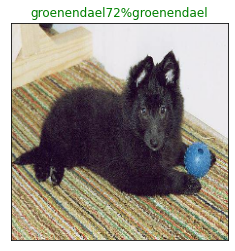

In [39]:
plot_pred(prediction_probabilities= predictions,
          images = val_images,
          labels = val_labels,
          n=77)

#### Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using get_pred_label().
* Find the top 10:
   * Prediction probabilities indexes
   * Prediction probabilities values
   * Prediction labels
   * Plot the top 10 prediction probability values and labels, coloring the true label green.

In [0]:
# View model's top 10 predictions
def plot_pred_conf(prediction_probabilities, labels, n=1):
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidenece indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]    # [::-1] reverses the order
  # find top 10 predicition confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = 'grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels =top_10_pred_labels,
             rotation = 'vertical')
  
  # change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels== true_label)].set_color('green')
  else:
    pass

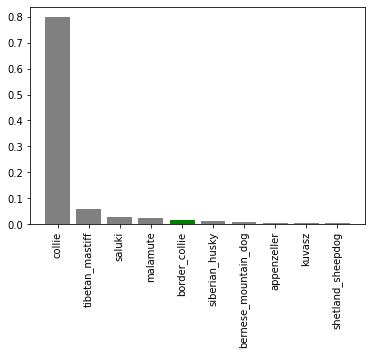

In [52]:
plot_pred_conf(prediction_probabilities=predictions,
               labels = val_labels,
               n=9)

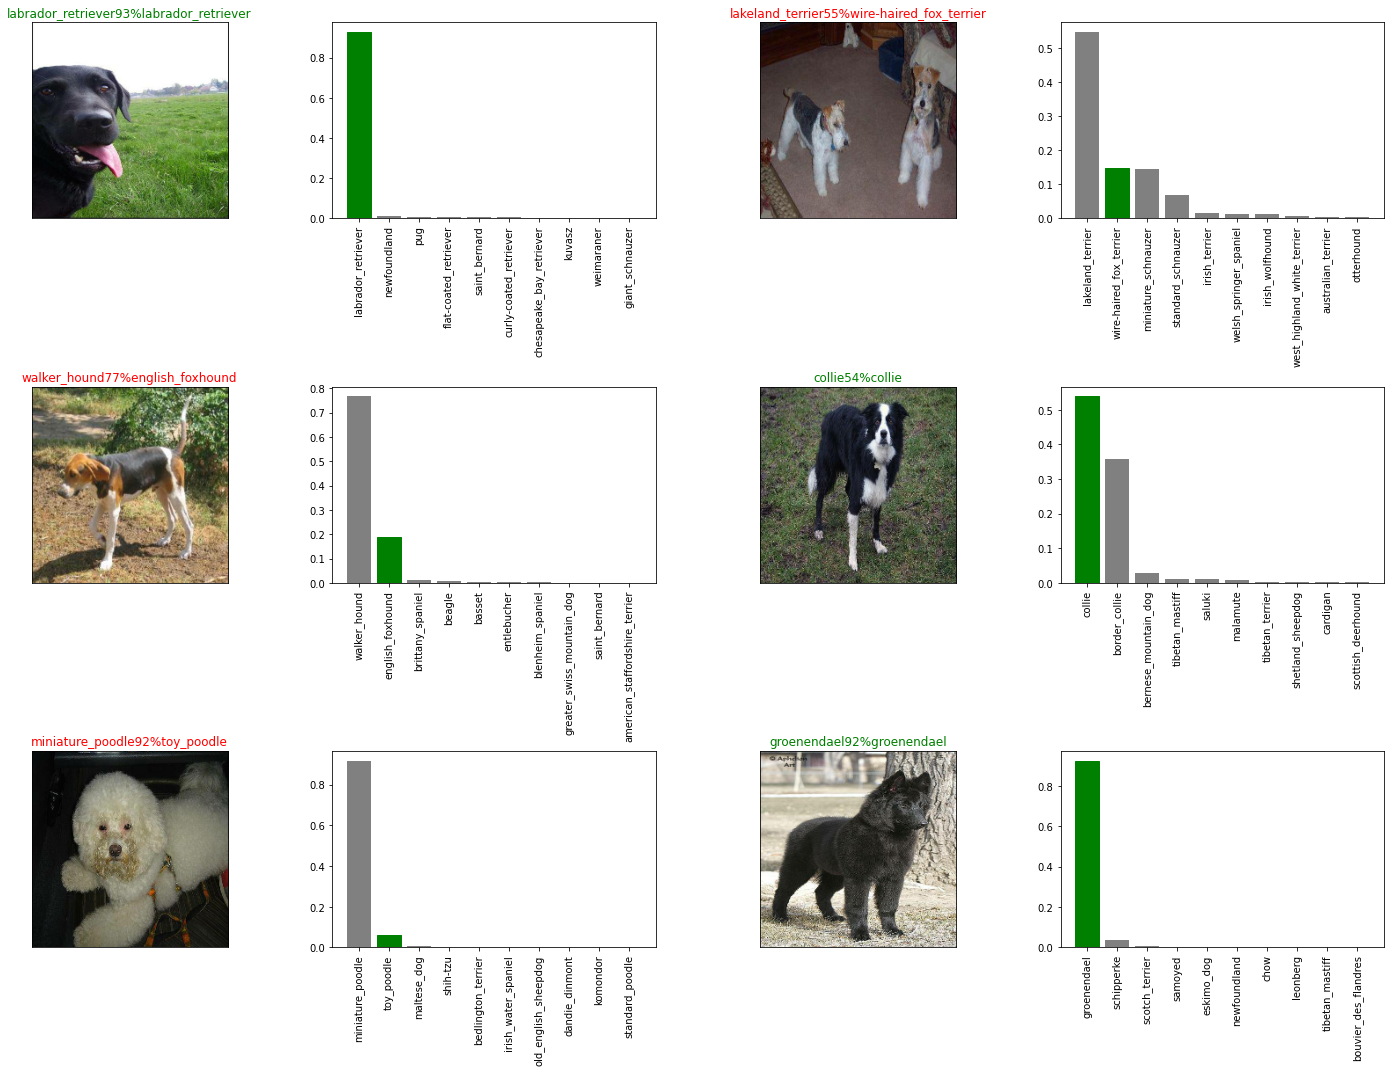

In [56]:
# Let's check a few predictions and their different values
i_multiplier = 40
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [97]:
from sklearn.metrics import confusion_matrix

true_lab = val_labels
pred_lab=[]
for i in range(len(predictions)):
  pred_lab.append(unique_breeds[np.argmax(predictions[i])])

confusion_matrix(true_lab, pred_lab)

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### Saving and reloading a trained model

In [0]:
# Save a model
def save_model(model, suffix ='None'):
  '''
  Saves the model in model directory and appends the suffix in the end
  '''
  # crreates model directory path name with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/Models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir+"-" + suffix+ ".h5"   # saved  file format
  print(f"SAving model to --> {modeldir}.....")
  model.save(model_path)
  return model_path

In [0]:
# Load a saved model
def load_model(model_path):
  print(f"Loading saved model from : {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

In [102]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetV2-Adam")

SAving model to --> drive/My Drive/Dog Vision/Models/20200524-10051590314738.....


'drive/My Drive/Dog Vision/Models/20200524-10051590314738-1000-images-mobilenetV2-Adam.h5'

In [103]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/Models/20200524-10051590314738-1000-images-mobilenetV2-Adam.h5")

Loading saved model from : drive/My Drive/Dog Vision/Models/20200524-10051590314738-1000-images-mobilenetV2-Adam.h5


In [104]:
# Evaluate pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 150ms/step - loss: 1.2872 - accuracy: 0.6700


[1.287222146987915, 0.6700000166893005]

In [105]:
# Evaluate the laoded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 153ms/step - loss: 1.2872 - accuracy: 0.6700


[1.287222146987915, 0.6700000166893005]

## Training the model on all the data

In [106]:
# create data batch with full dataset
full_data = create_data_batches(X,y)

Creating training data batches...


In [107]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [108]:
# create model for full model
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks = callbacks helps to track performance of model and compare with others
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

**NOTE :** Running the below cell will take sometime (maybe upto 1 hour 30 min) because the GPU we're using in the runtime will load all the images into memory.

In [110]:
# Fit the full model to full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks= [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 6066s 19s/step - loss: 1.3378 - accuracy: 0.6695
Epoch 2/100
320/320 [==============================] - 66s 205ms/step - loss: 0.4010 - accuracy: 0.8815
Epoch 3/100
320/320 [==============================] - 66s 206ms/step - loss: 0.2373 - accuracy: 0.9344
Epoch 4/100
320/320 [==============================] - 65s 203ms/step - loss: 0.1529 - accuracy: 0.9641
Epoch 5/100
320/320 [==============================] - 66s 206ms/step - loss: 0.1069 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 66s 205ms/step - loss: 0.0775 - accuracy: 0.9880
Epoch 7/100
320/320 [==============================] - 67s 209ms/step - loss: 0.0574 - accuracy: 0.9928
Epoch 8/100
320/320 [==============================] - 67s 210ms/step - loss: 0.0464 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 66s 206ms/step - loss: 0.0378 - accuracy: 0.9957
Epoch 10/100
320/320 [==============================] - 65s 203m

In [111]:
# Save our FULL model trained on FULL data images
save_model(full_model, suffix="full-image-set-mobilenetV2-Adam")

SAving model to --> drive/My Drive/Dog Vision/Models/20200524-12271590323274.....


'drive/My Drive/Dog Vision/Models/20200524-12271590323274-full-image-set-mobilenetV2-Adam.h5'

In [112]:
# load Full model
loaded_full_model = load_model("drive/My Drive/Dog Vision/Models/20200524-12271590323274-full-image-set-mobilenetV2-Adam.h5")

Loading saved model from : drive/My Drive/Dog Vision/Models/20200524-12271590323274-full-image-set-mobilenetV2-Adam.h5


## Making predicitons on Test Dataset

Since our model was trained on images in form of tensor batches, we will convert test data in same form.

' create_data_batches()' --> Takes list of filenames as inputs and converts them into tensor batches

Steps:
* Get the test image filenames
* Convert file names into test data batches using 'create_data_batches' and setting 'test_data' parameter to true (since test data doesn't have labels)
* Make a predicitons array by passing test batches to 'predict()' method called on our label


In [122]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/Data/test/f4e1d93f8d4f389547d69a5cd468e49d.jpg',
 'drive/My Drive/Dog Vision/Data/test/f5ae72b9aff8a7671358eb22a54229bc.jpg',
 'drive/My Drive/Dog Vision/Data/test/f569c5b12fae4ca37d376d21bc05f2b3.jpg',
 'drive/My Drive/Dog Vision/Data/test/f592d6ca12a9d99c18f26260c3eb148a.jpg',
 'drive/My Drive/Dog Vision/Data/test/f596d629c90c70820c38a094f03be387.jpg',
 'drive/My Drive/Dog Vision/Data/test/f4eb6450497df847ef1012d61d869007.jpg',
 'drive/My Drive/Dog Vision/Data/test/f540547111a9b6bda288b694a5536702.jpg',
 'drive/My Drive/Dog Vision/Data/test/f453249b8fff37e92e02fce0d662ffa0.jpg',
 'drive/My Drive/Dog Vision/Data/test/f575720280425098d6faca42cff69a36.jpg',
 'drive/My Drive/Dog Vision/Data/test/f5a6e430c2c363335d22ae0593d7533a.jpg']

In [123]:
len(test_filenames)

10357

In [124]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches ...


In [125]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note :** Calling predict on full model and passing test data batch will take a long time to run (about an hour)

In [129]:
# Make predictions on full test data using loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 6099s 19s/step


In [0]:
# Save predicitons (NumPy array) to csv file (to access later)
np.savetxt("drive/My Drive/Dog Vision/Model Prediction csv/preds_array_Radha.csv", test_predictions, delimiter =",")

In [0]:
# load Predictions (Numpy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/Model Prediction csv/preds_array_Radha.csv", delimiter=',')

In [132]:
test_predictions[:10]

array([[1.96539117e-12, 9.99992490e-01, 7.50852935e-10, ...,
        9.17871557e-10, 2.14084189e-13, 5.81216770e-13],
       [6.77808124e-13, 2.07478848e-07, 2.10098761e-11, ...,
        8.02062791e-11, 6.96362564e-13, 1.23009267e-14],
       [5.47923435e-07, 7.42317943e-11, 8.82613427e-10, ...,
        3.17917817e-08, 1.99080091e-07, 3.27679004e-07],
       ...,
       [3.92617839e-12, 2.22524343e-15, 7.00456776e-11, ...,
        1.20976553e-11, 2.69081225e-13, 4.09168854e-14],
       [5.84090339e-13, 8.73908313e-13, 6.88161377e-12, ...,
        2.14997638e-11, 1.20280716e-10, 6.92576918e-07],
       [3.00340507e-05, 3.64505581e-06, 1.97527897e-11, ...,
        6.17573787e-12, 1.61747116e-10, 2.57060367e-12]])

In [135]:
test_predictions.shape

(10357, 120)

### Preparing test dataset predictions for Kaggle submission

According to Kaggle, it wants our model's prediction probability outputs in a csv with an ID column and a column for each different dog breed. 
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

We will:
* Create a pandas dataframe with an ID col and a col for each diff dog breed
* Add data to ID col by extracting test image Ids from test file path
* Add data (prediction probabilites) to each of the dog breed column
* Export dataframe as a csv and submit it to Kaggle

In [136]:
# create pandas data frame
preds_df = pd.DataFrame( columns= ["Id"]+ list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [Id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [146]:
# Append test image ids to prediction dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:2]

['f4e1d93f8d4f389547d69a5cd468e49d', 'f5ae72b9aff8a7671358eb22a54229bc']

In [0]:
preds_df["Id"] = test_ids

In [148]:
preds_df.head()

Id  ... yorkshire_terrier
0  f4e1d93f8d4f389547d69a5cd468e49d  ...               NaN
1  f5ae72b9aff8a7671358eb22a54229bc  ...               NaN
2  f569c5b12fae4ca37d376d21bc05f2b3  ...               NaN
3  f592d6ca12a9d99c18f26260c3eb148a  ...               NaN
4  f596d629c90c70820c38a094f03be387  ...               NaN

[5 rows x 121 columns]

In [149]:
# Add prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

Id  ... yorkshire_terrier
0  f4e1d93f8d4f389547d69a5cd468e49d  ...       5.81217e-13
1  f5ae72b9aff8a7671358eb22a54229bc  ...       1.23009e-14
2  f569c5b12fae4ca37d376d21bc05f2b3  ...       3.27679e-07
3  f592d6ca12a9d99c18f26260c3eb148a  ...       1.25782e-10
4  f596d629c90c70820c38a094f03be387  ...       9.35347e-11

[5 rows x 121 columns]

In [0]:
# Export our predictions dataframe to csv to submit to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/Output CSV for Kaggle/full_model_predictions_submission_1_mobilenetV2.csv",
                index = False)

### Making predictions on custom images

To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using 'create_data_batches()'. And since our custom images won't have labels, we set the 'test_data' parameter to 'True'.
* Pass the custom image data batch to our model's 'predict()' method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.


In [154]:
# get custom image filepath
custom_path = 'drive/My Drive/Dog Vision/Data/My Dog photos/'
custom_image_paths =[custom_path+ fname for fname in os.listdir(custom_path)]
custom_image_paths

['drive/My Drive/Dog Vision/Data/My Dog photos/dog1.jpg',
 'drive/My Drive/Dog Vision/Data/My Dog photos/dog3.jpg',
 'drive/My Drive/Dog Vision/Data/My Dog photos/dog2.jpg']

In [155]:
# turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches ...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on custom data
custom_preds = loaded_full_model.predict(custom_data)

In [157]:
custom_preds.shape

(3, 120)

In [158]:
# get custom image prediction labels
custom_preds_label = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_label

['maltese_dog', 'golden_retriever', 'boxer']

In [0]:
# get custom images (unbatchify() function won't work since there are no labels here)
custom_images= []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

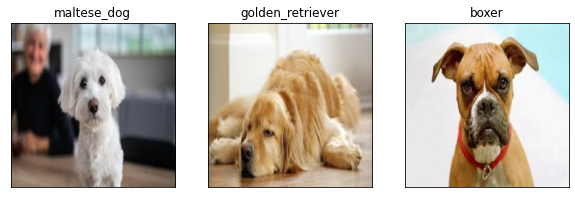

In [162]:
# check custom image predictions
plt.figure(figsize = (10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)     # row, col, index
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_label[i])
  plt.imshow(image)